In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from datos import Datos
from estrategiasparticionado.validacion_cruzada import ValidacionCruzada
from estrategiasparticionado.validacion_simple import ValidacionSimple
from clasificadores.clasificador_naive_bayes import ClasificadorNaiveBayes

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import numpy as np
import itertools 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [3]:
# Cargar datasets
dataset = dataset=Datos('./conjunto_datos/tic-tac-toe.data')
encAtributos = preprocessing.OneHotEncoder(categorical_features=dataset.nominalAtributos[:-1],sparse=False)
X = encAtributos.fit_transform(dataset.datos[:,:-1])
Y = dataset.datos[:,-1] 
class_names = sorted(dataset.diccionarios[-1].keys())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

In [4]:
# Clasificador
laplace_smoothing = 0
model = MultinomialNB()

In [5]:
# Validacion cruzada

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=1)
scores = cross_val_score(model, X, Y, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.04)


In [6]:
# Entrenamiento para el caso de validacion simple
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("Accuracy: %0.2f" % (score))
cnf_matrix = confusion_matrix(Y_test, model.predict(X_test))

Accuracy: 0.70


Confusion matrix, without normalization
[[ 57  74]
 [ 41 212]]
Normalized confusion matrix
[[ 0.4351145   0.5648855 ]
 [ 0.16205534  0.83794466]]


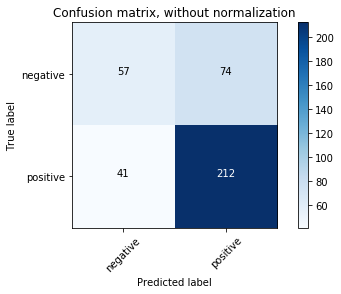

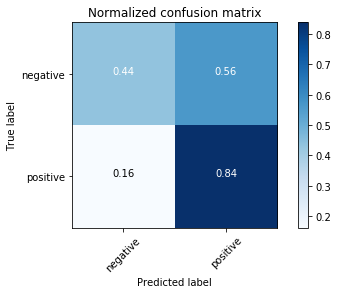

In [7]:
# Mostrar matrices de confusion
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import clasificadores.clasificador_naive_bayes as nb
import estrategiasparticionado.validacion_cruzada as vc
import estrategiasparticionado.validacion_simple as vs
from datos import Datos

dataset = Datos('./conjunto_datos/tic-tac-toe.data')

#dataset.datos = dataset.datos[::10,-3:]
#dataset.diccionarios = dataset.diccionarios[-3:]
#dataset.nombreAtributos = dataset.nombreAtributos[-3:]
#dataset.tipoAtributos = dataset.tipoAtributos[-3:]
#dataset.nominalAtributos = dataset.nominalAtributos[-3:]

print(dataset.datos)

clasificador = nb.ClasificadorNaiveBayes()
estrategia_vc = vc.ValidacionCruzada()
estrategia_vs = vs.ValidacionSimple()

estrategia_vs.creaParticiones(dataset.datos)

res_1 = clasificador.validacion(estrategia_vs, dataset)
clasificador.errores
#res_2 = clasificador.validacion(estrategia_vc, dataset)






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[[ 2.  2.  2. ...,  1.  1.  1.]
 [ 2.  2.  2. ...,  2.  1.  1.]
 [ 2.  2.  2. ...,  1.  2.  1.]
 ..., 
 [ 1.  2.  1. ...,  1.  2.  0.]
 [ 1.  2.  1. ...,  1.  2.  0.]
 [ 1.  1.  2. ...,  2.  2.  0.]]


[0.29850746268656714]

In [53]:
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV

dataset = dataset=Datos('./conjunto_datos/wdbc.data')
encAtributos = preprocessing.OneHotEncoder(categorical_features=dataset.nominalAtributos[:-1],sparse=False)
X = encAtributos.fit_transform(dataset.datos[:,:-1])
Y = dataset.datos[:,-1] 
class_names = sorted(dataset.diccionarios[-1].keys())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, Y_train)
clf = Pipeline([
 ('feature_selection', SelectFromModel(lsvc)),
 ('classification', LogisticRegression())
])
print('SelectFromModel')
clf.fit(X_test, Y_test)
print('Score: %f' % clf.score(X_test, Y_test))
print(clf.named_steps['feature_selection'].get_support())


print('SelectKBest')
K = len(dataset.diccionarios) # Busca en grid de 1 hasta K
pipeline = Pipeline([('kbest', SelectKBest(f_classif)), ('lr', LogisticRegression())])
grid_search = GridSearchCV(pipeline, {'kbest__k': range(1,K), 'lr__C': np.logspace(-10, 10, 5)})
grid_search.fit(X_train, Y_train)
print('Score: %f' % clf.score(X_test, Y_test))
print(clf.named_steps['feature_selection'].get_support())

SelectFromModel
Score: 0.951754
[False False  True  True False False False False False False False False
 False  True False False False False False False False  True False  True
 False False False False False False]
SelectKBest
Score: 0.951754
[False False  True  True False False False False False False False False
 False  True False False False False False False False  True False  True
 False False False False False False]


In [30]:
lsvc.score(X_test, Y_test)

0.94736842105263153